# 1. LIBRARY IMPORTS

In [1]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering Libraries
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Visualization Libraries
import plotly.graph_objects as go
import plotly.express as px

# Project-Specific Imports
from replay_reader import ReplayData, WotMap
from targeting import get_ticked_stream_wrapper
from wg_replay_reader.replay_reader import ReplayStreams
import json

# 2. CONSTANTS & PATHS

In [2]:
# Updated constants for splitting the game
START_TICKS = 600  # First 600 ticks (1 minute)
END_TICKS = 600    # Last 600 ticks (1 minute)

# (Optional) Default label mapping if needed
CLUSTER_LABELS = {
    0: "Defender",
    1: "Attacker",
    2: "Support",
    3: "Sniper"
}
# Paths
# Update these paths as needed for your local setup
REPLAYS_DIR = "C:\\Users\\kraso\\Desktop\\practical work\\replays\\replays"
ReplayData.set_base_replay_folder(REPLAYS_DIR)

META_PATH = ("C:\\Users\\kraso\\Desktop\\practical work\\replays\\replays\\01681217104.wotx.wotconslna.350870444529177.04_himmelsdorf.wotsrvreplay\\meta.json")

REPLAY_PATH = ReplayData.load_by_name("C:\\Users\\kraso\\Desktop\\practical work\\replays\\replays\\01681217104.wotx.wotconslna.350870444529177.04_himmelsdorf.wotsrvreplay")

# Path to the json file containing the vehicle roles predefined by game
JSON_PATH = "C:\\Users\\kraso\\Desktop\\practical work\\code\\code\\replays-research-environment-e550b891532cfdb1ff352d467450740b5da64e76\\replays-research-environment\\wg_replay_reader\\data\\vehicles_roles.json"

# 3. DATA LOADING FUNCTIONS

In [3]:
def load_meta_data(meta_path):
    """Load replay metadata and extract tank models."""
    with open(meta_path, 'r') as f:
        meta_data = json.load(f)
    vehicles_info = meta_data["vehicles_info"]
    tank_models = {str(vid): info["modelName"] for vid, info in vehicles_info.items()}
    return meta_data, vehicles_info, tank_models

def load_vehicle_roles(json_path):
    """Load predefined tank roles from a JSON file."""
    with open(json_path, "r") as f:
        vehicle_roles = json.load(f)

    tank_roles = {tank_model: info for tank_model, info in vehicle_roles.items()}
    return tank_roles


def extract_data(replay):
    """Extract position, yaw, speed, and health data from the replay."""
    position_data, mapping = get_ticked_stream_wrapper(replay, ReplayStreams.EStreamName.position)
    yaw_data, _ = get_ticked_stream_wrapper(replay, ReplayStreams.EStreamName.yaw)
    # Here tank roll data of the tank is called speed to avoid misunderstanding what "roll" means
    speed_data, _ = get_ticked_stream_wrapper(replay, ReplayStreams.EStreamName.roll)
    health_data, _ = get_ticked_stream_wrapper(replay, ReplayStreams.EStreamName.health)
    return position_data, yaw_data, speed_data, health_data, mapping

# 4. FEATURE ENGINEERING FUNCTIONS

In [4]:
def split_game_ticks(total_ticks):
    """
    Splits the total game duration into:
      - Start Game: first 600 ticks
      - Mid Game 1, Mid Game 2, Mid Game 3: the middle portion
      - End Game: last 600 ticks
    """
    if total_ticks <= (START_TICKS + END_TICKS):
        print("Warning: total_ticks too small; can't split properly.")
        return {
            "Start Game": range(0, min(total_ticks, START_TICKS)),
            "Mid Game 1": range(0, 0),
            "Mid Game 2": range(0, 0),
            "Mid Game 3": range(0, 0),
            "End Game": range(0, 0)
        }
    mid_game_ticks = total_ticks - (START_TICKS + END_TICKS)
    mid_game_split = mid_game_ticks // 3
    return {
        "Start Game": range(0, START_TICKS),
        "Mid Game 1": range(START_TICKS, START_TICKS + mid_game_split),
        "Mid Game 2": range(START_TICKS + mid_game_split, START_TICKS + 2 * mid_game_split),
        "Mid Game 3": range(START_TICKS + 2 * mid_game_split, total_ticks - END_TICKS),
        "End Game": range(total_ticks - END_TICKS, total_ticks),
    }

def compute_features(position_data, yaw_data, speed_data, health_data, tank_models, mapping, max_tick):
    """Create a DataFrame of features from the replay data."""
    rows = []
    n_players = mapping.shape[0]
    n_ticks = position_data.shape[0]
    for col_idx in range(n_players):
        vid = mapping[col_idx] # The real vehicle ID
        # For each tick, gather data
        for tick_index in range(n_ticks):
            pos = position_data[tick_index, col_idx, ...]
            speed_val = speed_data[tick_index, col_idx, ...]
            yaw_val = yaw_data[tick_index, col_idx, ...]
            health_val = health_data[tick_index, col_idx, ...]
            x_coord, _, y_coord = pos[0], pos[1], pos[2]
            rows.append({
                "player_id": vid, "TankModel": tank_models.get(str(vid), "UnknownTank"),
                "tick": tick_index, "Health": float(health_val), "Speed": float(speed_val),
                "Yaw": float(yaw_val), "PosX": float(x_coord), "PosY": float(y_coord)
            })
    return pd.DataFrame(rows)

def filter_features_by_period(features: pd.DataFrame, tick: int, max_tick: int):
    """Find which game phase 'tick' belongs to, then return only features for that entire phase range."""
    phases = split_game_ticks(max_tick)
    for phase_name, tick_range in phases.items():
        if tick in tick_range:
            mask = features["tick"].isin(tick_range)
            return features[mask].copy(), phase_name
    return features, "Unknown Period"

# 5. CLUSTERING FUNCTIONS (K-MEANS)

In [5]:
def cluster_tanks_kmeans(features, tick, max_tick, n_clusters=4):
    """
    Clusters tanks using KMeans on alive tanks within the game phase.
    Filters out tanks with 0 health.
    """
    # 1) Filter by period
    filtered_features, game_period = filter_features_by_period(features, tick, max_tick)

    # 2) Exclude dead (0 health) tanks
    alive = filtered_features[filtered_features["Health"] > 0].copy()
    if alive.empty:
        print("No alive tanks in this phase!")
        return filtered_features, game_period  # Nothing to cluster

    # 3) Prepare numeric data for clustering
    numeric = alive.drop(columns=["player_id", "TankModel", "tick"], errors='ignore')
    scaler = StandardScaler()
    scaled = scaler.fit_transform(numeric)

    # 4) Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled)
    alive["KMeans_Cluster"] = labels

    # 5) Merge cluster labels back into filtered_features
    merged = pd.merge(
        filtered_features,
        alive[["player_id", "tick", "KMeans_Cluster"]],
        on=["player_id", "tick"],
        how="left"
    )

    return merged, game_period

def assign_roles_to_clusters(features: pd.DataFrame, cluster_column: str, method: str):
    """Dynamically assign roles to clusters based on quantitative feature analysis."""
    # For numeric stats
    cluster_means = features.groupby(cluster_column).mean(numeric_only=True)
    role_mapping = {}

    for cluster, row in cluster_means.iterrows():
        if (row.get("Health",0) > features["Health"].quantile(0.85) and
            row.get("Speed",0) < features["Speed"].quantile(0.15)):
            role_mapping[cluster] = "Defender"
        elif (row.get("Speed",0) > features["Speed"].quantile(0.85) and
              row.get("Speed",0) > features["Speed"].quantile(0.85)): 
            role_mapping[cluster] = "Attacker"
        elif (row.get("Yaw",0) > features["Yaw"].quantile(0.85)):
            role_mapping[cluster] = "Support"
        else:
            role_mapping[cluster] = "Sniper"

    return role_mapping

def track_cluster_changes(
    all_data: pd.DataFrame, 
    cluster_col: str = "KMeans_Cluster",
    cluster_label_map: dict = None
):
    """Detects changes in cluster assignment over time,
    printing them with cluster names and including tank model."""
    if cluster_label_map is None:
        # Default label mapping if not provided
        cluster_label_map = {
            0: "Defender", 
            1: "Attacker", 
            2: "Support", 
            3: "Sniper"
        }

    # Sort by player and tick
    all_data = all_data.sort_values(["player_id", "tick"]).copy()

    changes = []
    prev_cluster_for_player = {}  # {player_id: (cluster_id, tank_model)}

    for idx, row in all_data.iterrows():
        pid = row["player_id"]
        t   = row["tick"]
        c   = row.get(cluster_col, np.nan)
        tank_model = row.get("TankModel", "UnknownTank")

        # Skip if cluster is NaN
        if pd.isna(c):
            continue

        if pid not in prev_cluster_for_player:
            # first time we see this player
            prev_cluster_for_player[pid] = (c, tank_model)
        else:
            (old_c, old_model) = prev_cluster_for_player[pid]
            if old_c != c:
                # We have a cluster change
                old_name = cluster_label_map.get(old_c, f"Cluster {old_c}")
                new_name = cluster_label_map.get(c,    f"Cluster {c}")

                changes.append((pid, tank_model, t, old_name, new_name))

                # Update stored cluster
                prev_cluster_for_player[pid] = (c, tank_model)
            else:
                # same cluster, just keep going
                pass

    # Print them
    if changes:
        for (pid, model, tick_num, old_cluster_name, new_cluster_name) in changes:
            print(
                f"Player {pid} ({model}) changed from {old_cluster_name} "
                f"to {new_cluster_name} at tick {tick_num}"
            )
    else:
        print("No cluster changes found.")

    return changes


# 6. VISUALIZATION FUNCTIONS

In [6]:
def plot_player_movements(
    all_data: pd.DataFrame,
    cluster_col: str = "KMeans_Cluster",
    fig_size=(10, 6),
    title="Player Movements with Cluster Changes (K-Means)"
    ):
    """Plots each player's movement (PosX, PosY) over ticks and highlights where cluster assignment changed."""
    # Sort the data
    all_data = all_data.sort_values(["player_id", "tick"]).copy()

    # Prepare the figure
    plt.figure(figsize=fig_size)

    # We'll group by each player and plot their path
    grouped = all_data.groupby("player_id")

    for player_id, df_player in grouped:
        # Sort by tick
        df_player = df_player.sort_values("tick")

        # Extract positions
        x_vals = df_player["PosX"].values
        y_vals = df_player["PosY"].values

        # Plot the path
        plt.plot(
            x_vals, 
            y_vals, 
            label=f"Player {player_id}"
        )

        # Now find cluster changes for this player
        prev_cluster = None
        for i in range(len(df_player)):
            c = df_player.iloc[i].get(cluster_col, np.nan)
            if i == 0:
                prev_cluster = c
                continue

            if pd.isna(c):
                # skip if no cluster
                continue

            if c != prev_cluster:
                # Mark this point with a special marker
                plt.scatter(
                    x_vals[i], 
                    y_vals[i], 
                    marker="o", 
                    s=100,
                    edgecolors="black",
                    facecolors="none",
                    label=f"Player {player_id} changed {prev_cluster} -> {c} at tick {df_player.iloc[i]['tick']}"
                )
                prev_cluster = c
            else:
                prev_cluster = c

    plt.xlabel("PosX")
    plt.ylabel("PosY")
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

def plot_interactive_tank_positions(
    replay,
    tick,
    clusters,
    mapping,
    max_tick,
    cluster_label_map=None
):
    """Plot each player's position as a scatter marker on the map,
    color by K-Means cluster, including player ID and TankModel in hover text."""
    if cluster_label_map is None:
        cluster_label_map = {0: "Defender", 1: "Attacker", 2: "Support", 3: "Sniper"}

    # 1) Filter to relevant phase
    filtered, game_period = filter_features_by_period(clusters, tick, max_tick)

    # 2) Get positions at this tick
    position_stream, _ = get_ticked_stream_wrapper(replay, ReplayStreams.EStreamName.position)
    wot_map = WotMap(name=replay.map, try_default_image=True)
    positions_at_tick = position_stream[tick]
    map_positions = wot_map.raw_to_image_coordinates(positions_at_tick[:, [0, 2]])

    fig = px.imshow(wot_map.map_rgb)

    n_players = mapping.shape[0] if hasattr(mapping, "shape") else len(mapping)

    cluster_colors = {0: "red", 1: "blue", 2: "green", 3: "purple"}

    for col_idx in range(n_players):
        vid = mapping[col_idx]
        rowset = filtered.loc[
            (filtered["player_id"] == vid) &
            (filtered["tick"] == tick)
        ]
        if rowset.empty:
            continue

        row = rowset.iloc[0]
        cluster_id = row.get("KMeans_Cluster", np.nan)
        if pd.isna(cluster_id):
            # no cluster assigned
            continue

        # Translate cluster ID to role name
        role_name = cluster_label_map.get(cluster_id, f"Cluster {cluster_id}")

        # Extract color if any
        color = cluster_colors.get(cluster_id, "gray")

        # Player ID & Tank
        player_id = row["player_id"]
        tank_model = row.get("TankModel", "UnknownTank")

        # Health if needed
        hp   = row.get("Health", 0)

        if col_idx >= len(map_positions):
            continue

        x, y = map_positions[col_idx]

        # Build enriched hover text
        hover_text = (
            f"Player: {player_id}<br>"
            f"Tank: {tank_model}<br>"
            f"Role: {role_name}<br>"
            f"Health: {hp:.0f}<br>"
            
            
        )

        fig.add_trace(go.Scatter(
            x=[x],
            y=[y],
            mode="markers",
            marker=dict(size=12, color=color),
            text=[hover_text],
            hoverinfo="text",
            name=f"{player_id} - {tank_model}"
        ))

    fig.update_layout(
        title=f"Tank Positions (K-Means) at Tick {tick} | Period: {game_period}",
        showlegend=True
    )
    fig.show()
    
def plot_feature_distributions(features, cluster_column, method, tick, max_tick):
    """
    Show feature distributions across clusters in separate plots in one figure.
    Filters out unexpected clusters (like NaN) and aligns cluster palette correctly.
    """
    features, game_period = filter_features_by_period(features, tick, max_tick)

    feature_names = ["Speed", "Yaw", "PosX", "PosY", "Health"]

    features[cluster_column] = features[cluster_column].astype(str)

    valid_clusters = {"0.0", "1.0", "2.0", "3.0"}
    features = features[features[cluster_column].isin(valid_clusters)]

    unique_clusters = features[cluster_column].unique()
    print(f"Unique clusters detected in {method}: {unique_clusters}")

    melted_data = features.melt(
        id_vars=[cluster_column],
        value_vars=feature_names,
        var_name="Feature",
        value_name="Value"
    )

    cluster_colors = {"0.0": "red", "1.0": "blue", "2.0": "green", "3.0": "purple"}
    cluster_labels = {"0.0": "Defender", "1.0": "Attacker", "2.0": "Support", "3.0": "Sniper"}

    g = sns.FacetGrid(melted_data, col="Feature", col_wrap=3, height=4, sharey=False)
    g.map_dataframe(sns.boxplot, x=cluster_column, y="Value", palette=cluster_colors)

    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("Cluster", "Value")

    handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10,
                          markerfacecolor=cluster_colors[str(i)], label=cluster_labels[str(i)])
               for i in unique_clusters if str(i) in cluster_colors]

    plt.legend(handles=handles, title="Cluster", loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0)

    plt.suptitle(f"Feature Distributions by {method} Cluster (Period: {game_period})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 0.85, 0.96])  # Adjust layout to fit title and legend
    plt.show()


# 7. ADDITIONAL FUNCTIONS
### (ALL TANK MODELS AND THEIR PREDEFINED ROLES IN THE GAME)

In [7]:
def merge_unique_tank_roles(clustered_data, roles_json_path):
    """
    Merge predefined tank roles only once per player-tank combination.
    """
    # Load predefined tank roles from JSON
    tank_roles = load_vehicle_roles(roles_json_path)

    # Extract unique player-tank combinations
    unique_players = clustered_data.drop_duplicates(subset=["player_id", "TankModel"]).copy()

    # Map predefined roles using TankModel
    unique_players["PredefinedRole"] = unique_players["TankModel"].map(tank_roles)

    # Handle missing values by replacing NaN with "Unknown"
    unique_players["PredefinedRole"] = unique_players["PredefinedRole"].fillna("Unknown")

    # Merge the predefined roles back into the original DataFrame
    clustered_data = clustered_data.drop(columns=["PredefinedRole"], errors='ignore')
    clustered_data = clustered_data.merge(unique_players[["player_id", "TankModel", "PredefinedRole"]],
                                          on=["player_id", "TankModel"], how="left")

    return clustered_data

# 7. EXECUTION

In [8]:
meta_data, _, tank_models = load_meta_data(META_PATH)

position_data, yaw_data, speed_data, health_data, mapping = extract_data(REPLAY_PATH)

max_tick = position_data.shape[0]
print(f"{max_tick} is the lenght of the game in ticks.")
print((f"{max_tick/10} is the lenght of the game in secconds."))

# Build features
features = compute_features(
        position_data, yaw_data, speed_data, health_data,
        tank_models, mapping, max_tick
    )

2706 is the lenght of the game in ticks.
270.6 is the lenght of the game in secconds.


In [9]:
# Choose a tick that belongs to [0, max_tick]
tick = 2700

In [10]:
# Apply K-Means Clustering
clustered_features_kmeans, game_period_kmeans = cluster_tanks_kmeans(features.copy(), tick, max_tick)
print("[K-Means] Period:", game_period_kmeans)

[K-Means] Period: End Game


In [11]:
#Plot Clustering Results (K-Means)
plot_interactive_tank_positions(REPLAY_PATH, tick, clustered_features_kmeans, mapping, max_tick)

Unique clusters detected in K-Means: ['0.0' '2.0' '3.0' '1.0']


c:\Users\kraso\Desktop\practical work\LOST.dir\LOST.dir\.venv\lib\site-packages\seaborn\axisgrid.py:854: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


c:\Users\kraso\Desktop\practical work\LOST.dir\LOST.dir\.venv\lib\site-packages\seaborn\axisgrid.py:854: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


c:\Users\kraso\Desktop\practical work\LOST.dir\LOST.dir\.venv\lib\site-packages\seaborn\axisgrid.py:854: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


c:\Users\kraso\Desktop\practical work\LOST.dir\LOST.dir\.venv\lib\site-packages\seaborn\axisgrid.py:854: FutureWarning:



Passing

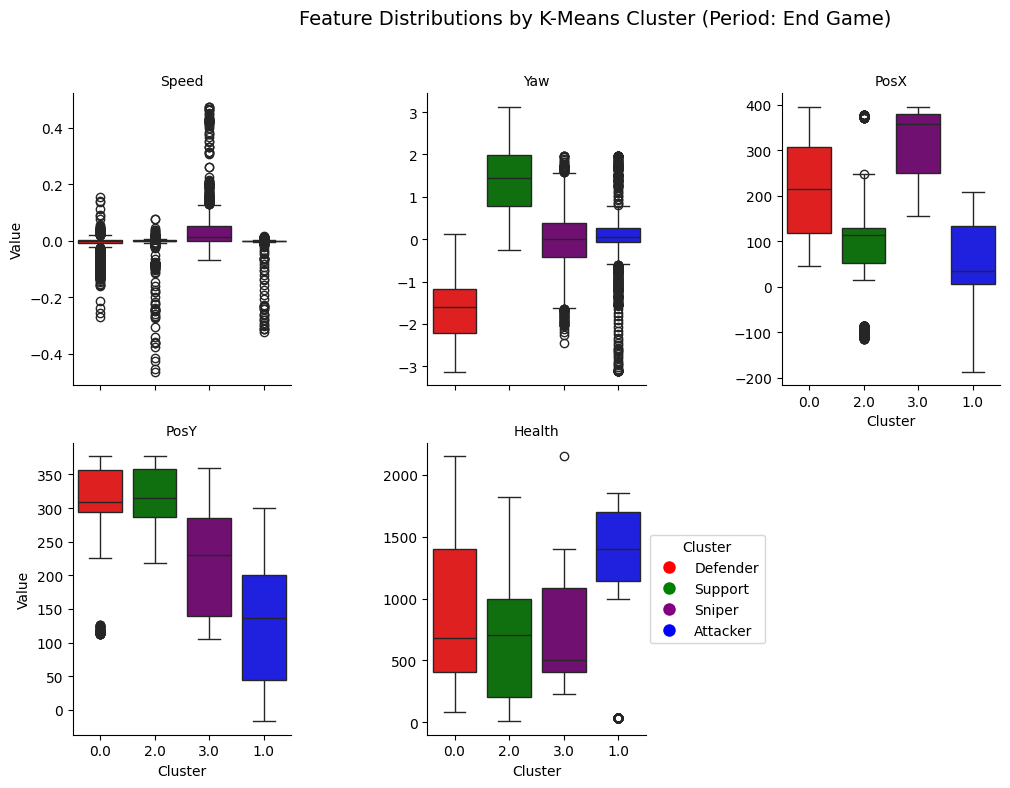

In [12]:
# Plot feature distribution for K-Means
plot_feature_distributions(clustered_features_kmeans, "KMeans_Cluster", "K-Means", tick, max_tick)


In [13]:
all_ticks_clustered = []

for tick in range(0, max_tick, 50):  # for example, cluster every 50 ticks
    # This will return a DataFrame with a new cluster column
    clustered_for_tick, period_name = cluster_tanks_kmeans(features.copy(), tick, max_tick)
    
    # Store these cluster assignments
    all_ticks_clustered.append(clustered_for_tick)

# Concatenate them into a single DataFrame
df_clustered = pd.concat(all_ticks_clustered, ignore_index=True).drop_duplicates(
    subset=["player_id", "tick"]
)

In [14]:
changes = track_cluster_changes(df_clustered, cluster_col="KMeans_Cluster")

# 'changes' is a list of tuples: (player_id, tick, old_cluster, new_cluster)
print("Detected cluster changes:")
for (pid, model, tick_num, old_cluster, new_cluster) in changes:
    print(f"Player {pid} ({model}) changed from {old_cluster} to {new_cluster} at tick {tick_num}")


Player 957709 (france:F36_AMX_AC_Mle1948) changed from Support to Defender at tick 12
Player 957709 (france:F36_AMX_AC_Mle1948) changed from Defender to Support at tick 261
Player 957709 (france:F36_AMX_AC_Mle1948) changed from Support to Defender at tick 339
Player 957709 (france:F36_AMX_AC_Mle1948) changed from Defender to Support at tick 366
Player 957709 (france:F36_AMX_AC_Mle1948) changed from Support to Defender at tick 489
Player 957709 (france:F36_AMX_AC_Mle1948) changed from Defender to Attacker at tick 504
Player 957709 (france:F36_AMX_AC_Mle1948) changed from Attacker to Support at tick 600
Player 957709 (france:F36_AMX_AC_Mle1948) changed from Support to Sniper at tick 1102
Player 957710 (ussr:R151_Object_257_2) changed from Defender to Support at tick 460
Player 957710 (ussr:R151_Object_257_2) changed from Support to Defender at tick 477
Player 957710 (ussr:R151_Object_257_2) changed from Defender to Sniper at tick 600
Player 957710 (ussr:R151_Object_257_2) changed from Sn

C:\Users\kraso\AppData\Local\Temp\ipykernel_20168\2557501367.py:63: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.



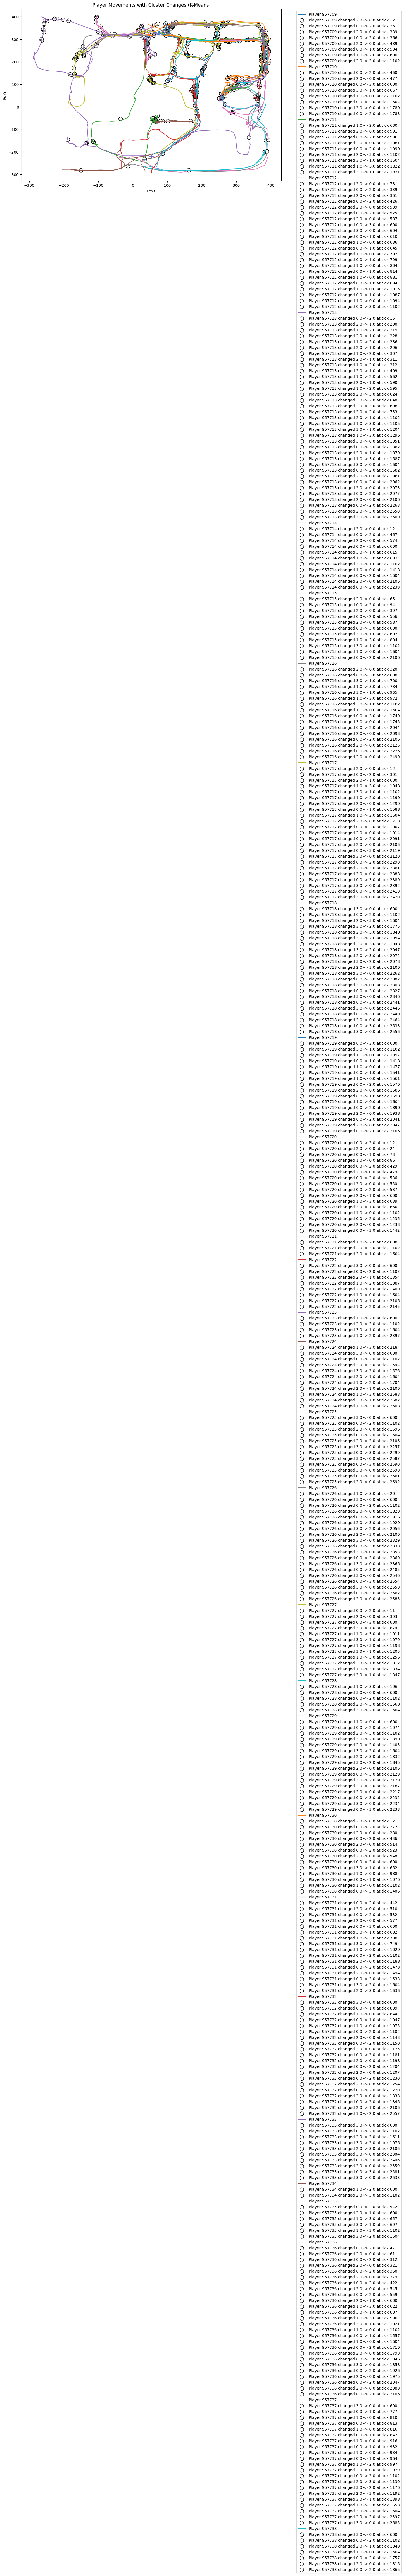

In [15]:
plot_player_movements(
    all_data=df_clustered,
    cluster_col="KMeans_Cluster",
    fig_size=(12, 8),
    title="Player Movements with Cluster Changes (K-Means)"
)


In [16]:
# Merge roles without duplication issues
clustered_features_kmeans = merge_unique_tank_roles(clustered_features_kmeans, JSON_PATH)

# Print Predefined Roles by Player ID and Tank Model Only Once
print("\nPredefined Roles by Player ID and Tank Model (Unique Only):")
print("-" * 70)

# Drop duplicate rows based on 'player_id' and 'TankModel'
unique_players = clustered_features_kmeans.drop_duplicates(subset=["player_id", "TankModel"])

# Iterate over unique players and print their info
for index, row in unique_players.iterrows():
    player_id = row["player_id"]
    tank_model = row["TankModel"]
    predefined_role = row["PredefinedRole"]

    print(f"Player ID: {player_id} | Tank Model: {tank_model} | Predefined Role: {predefined_role}")



Predefined Roles by Player ID and Tank Model (Unique Only):
----------------------------------------------------------------------
Player ID: 957709 | Tank Model: france:F36_AMX_AC_Mle1948 | Predefined Role: ATSPG_support
Player ID: 957710 | Tank Model: ussr:R151_Object_257_2 | Predefined Role: HT_break
Player ID: 957711 | Tank Model: usa:A140_ASTRON_REX_105mm | Predefined Role: MT_support
Player ID: 957712 | Tank Model: merc:MRC55_Chisel | Predefined Role: Unknown
Player ID: 957713 | Tank Model: france:F116_Bat_Chatillon_Bourrasque | Predefined Role: MT_support
Player ID: 957714 | Tank Model: uk:GB83_FV4005 | Predefined Role: ATSPG_support
Player ID: 957715 | Tank Model: germany:G55_E-75 | Predefined Role: HT_universal
Player ID: 957716 | Tank Model: germany:G133_Baer | Predefined Role: Unknown
Player ID: 957717 | Tank Model: usa:A95_T95_E6 | Predefined Role: MT_universal
Player ID: 957718 | Tank Model: ussr:R155_Object_277 | Predefined Role: HT_break
Player ID: 957719 | Tank Model: 